## **Initial Setup**

In [1]:
# Importing necessary libraries for image classification using FastAI
import fastai
import torch
import pandas as pd
import numpy as np
from fastai.vision.all import *
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import *
from pathlib import Path

In [2]:
# Printing the versions of FastAI and PyTorch for reference
print(fastai.__version__)
print(torch.__version__)

2.7.18
2.5.1+cu121


In [3]:
# Unzipping the dataset
!unzip "pnevmoniya.zip"

In [4]:
# Setting the path for the training dataset
path = Path('train')
path.iterdir()

<generator object Path.iterdir at 0x7f95c46729d0>

In [8]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="torch")

## **First Model. Training with resnet-34**



In [9]:
def data_loader_v1(data):
    pneumonia = DataBlock(
        blocks = (ImageBlock, CategoryBlock),
        get_items = get_image_files,
        get_y = parent_label,
        item_tfms = Resize(224)
    )

    dls = pneumonia.dataloaders(data)
    return dls

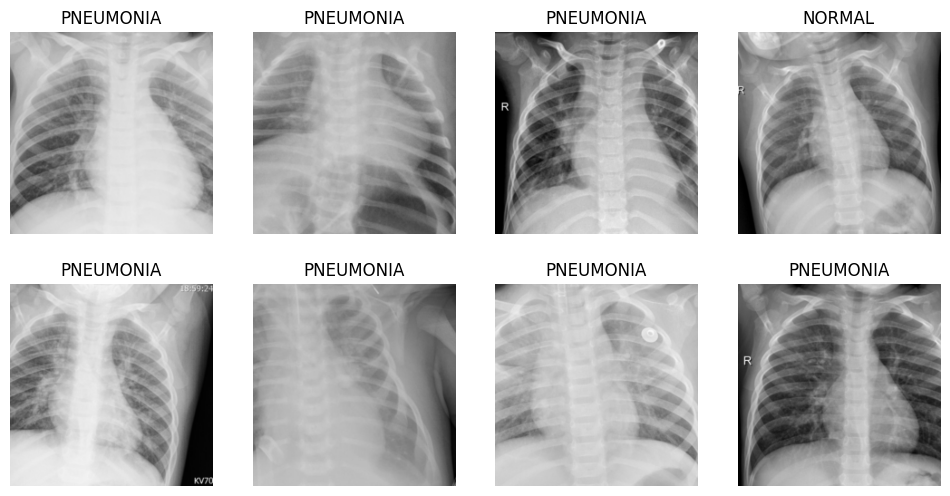

In [10]:
dls = data_loader_v1(path)
dls.train.show_batch(max_n=8, nrows=2)

In [11]:
model_v1 = vision_learner(dls, resnet34, metrics=accuracy)
model_v1.fine_tune(10)

epoch,train_loss,valid_loss,accuracy,time
0,0.459723,0.228500,0.919463,01:37


epoch,train_loss,valid_loss,accuracy,time
0,0.146275,0.072816,0.975072,01:38
1,0.102723,0.058943,0.979866,01:41
2,0.080680,0.073529,0.980825,01:42
3,0.055339,0.049055,0.984660,01:38
4,0.036542,0.053385,0.984660,01:40
5,0.023270,0.026089,0.992330,01:39
6,0.016074,0.027635,0.992330,01:39
7,0.010716,0.020285,0.994247,01:40
8,0.007475,0.022168,0.994247,01:37
9,0.004882,0.024095,0.993289,01:39


## **Second Model Training with resnet-50**

In [12]:
pneumonia = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=Resize(224),
    batch_tfms=[*aug_transforms(flip_vert=True, max_rotate=10, max_zoom=1.1, max_lighting=0.2, max_warp=0.2),
                Normalize.from_stats(*imagenet_stats)]
)

In [13]:
dls = pneumonia.dataloaders(path, bs=64)
model_v2 = vision_learner(dls, resnet50, metrics=[accuracy, Precision(), Recall(), F1Score()])

#### Instead of fixed epochs, I used learning rate finder to find the optimal learning rate

### **Learning Rate Optimization**

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

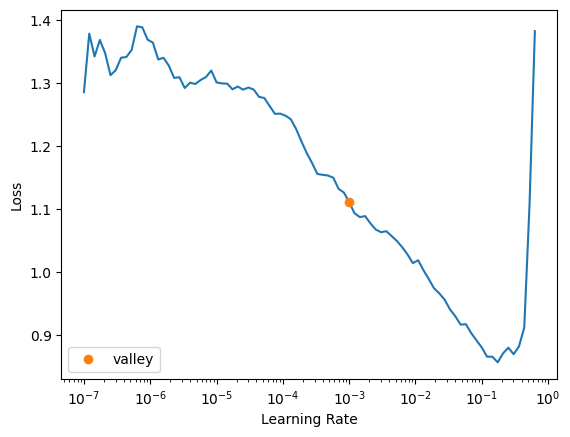

In [14]:
# Finding the optimal learning rate
lr_min = model_v2.lr_find()

In [15]:
# Fine-tuning the model for 10 epochs with the optimal learning rate
model_v2.fine_tune(10, base_lr=lr_min.valley)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.642402,0.189509,0.934803,0.950943,0.963057,0.956962,01:43


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.418362,0.183933,0.951103,0.984169,0.950318,0.966948,01:47
1,0.314478,0.164648,0.954938,0.974293,0.965605,0.969930,01:47
2,0.269437,0.174840,0.959732,0.985621,0.960510,0.972903,01:46
3,0.228908,0.126272,0.963567,0.983182,0.968153,0.975610,01:48
4,0.169692,0.100896,0.969319,0.978399,0.980892,0.979644,01:47
5,0.140048,0.087445,0.974113,0.978535,0.987261,0.982879,01:49
6,0.121740,0.081154,0.974113,0.976131,0.989809,0.982922,01:48
7,0.122228,0.081521,0.973154,0.978508,0.985987,0.982234,01:47
8,0.116654,0.080662,0.974113,0.974937,0.991083,0.982944,01:47
9,0.126418,0.090756,0.965484,0.964064,0.991083,0.977387,01:46


## **Results Evaluation**

#### **For model 1**

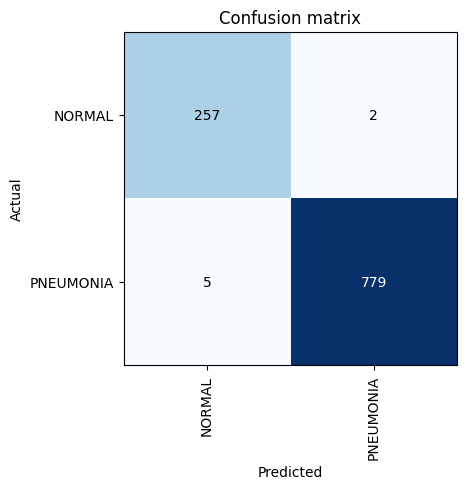

In [16]:
# Generating classification results
interp = ClassificationInterpretation.from_learner(model_v1)
# Plotting the confusion matrix
interp.plot_confusion_matrix()

In [17]:
# Printing the classification report with precision, recall, and F1-score
interp.print_classification_report()

              precision    recall  f1-score   support

      NORMAL       0.98      0.99      0.99       259
   PNEUMONIA       1.00      0.99      1.00       784

    accuracy                           0.99      1043
   macro avg       0.99      0.99      0.99      1043
weighted avg       0.99      0.99      0.99      1043



#### **For model 2**

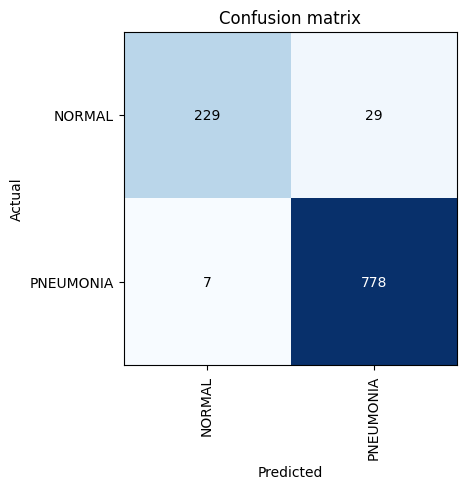

In [18]:
# Generating classification results
interp = ClassificationInterpretation.from_learner(model_v2)
# Plotting the confusion matrix
interp.plot_confusion_matrix()

In [19]:
# Printing the classification report with precision, recall, and F1-score
interp.print_classification_report()

              precision    recall  f1-score   support

      NORMAL       0.97      0.89      0.93       258
   PNEUMONIA       0.96      0.99      0.98       785

    accuracy                           0.97      1043
   macro avg       0.97      0.94      0.95      1043
weighted avg       0.97      0.97      0.96      1043



## **Predictions**

In [ ]:
df_sub = pd.read_csv('pnevmoniya/sample_solution.csv')
df_sub.head()

In [ ]:
for i in range(0,624):
    label = df_sub.iloc[i,0]
    img = PILImage.create(Path(f'pnevmoniya/test/{label}'))
    pred, _, prob = model_v2.predict(img)
    df_sub.iloc[i,1] = pred

In [ ]:
# Batch predictions for test set
test_images = get_image_files(Path('pnevmoniya/test'))
test_dl = dls.test_dl(test_images)
preds, _, probs = model_v2.get_preds(dl=test_dl)